# Livrable 1 : Classification Binaire
|Erwan Martin|Thibaut Liger-Hellard|Arnaud Maturel|Guillaume Le Cocguen|Victorien Goudeau|
|------------|---------------------|--------------|--------------------|-----------------|

# **Contexte**:
L'entreprise TouNum, spécialisée dans la numérisation de documents, collabore avec des spécialistes en Data Science de CESI pour développer une solution de Machine Learning capable de générer automatiquement des légendes pour les images numérisées. Ce projet vise à enrichir leur offre de services en répondant aux besoins de clients ayant d'importantes quantités de données à classer. Le défi inclut le nettoyage des images de qualité variable et la distinction entre photos et autres types d'images avant l'analyse. L'approche utilisera des technologies avancées telles que les réseaux de neurones convolutifs (CNN) et récurrents (RNN), en s'appuyant sur Python et des librairies spécialisées. Un prototype est attendu dans cinq semaines, suivi d'une présentation détaillée et d'une discussion sur l'intégration et la maintenance de la solution.

# **Objectif**:

L'objectif de ce projet est de développer un modèle de classification binaire capable de distinguer les images de photos des autres types d'images. Le modèle sera entraîné sur un jeu de données étiqueté et évalué sur un jeu de données de test distinct. Les performances du modèle seront mesurées en termes de précision, de rappel et de F1-score. Le modèle final sera évalué sur un ensemble de données non étiqueté pour tester sa capacité à généraliser à de nouvelles images.

# **Données**:

Notre jeu de données contient plusieurs milliers d'images de différentes tailles et qualités. Ces images ne sont pas étiquetées, mais les images étant bien archivées, nous allons pouvoir les étiquetter manuellement.

# **Défis techniques**:

- Étiquettage des données: Les images ne sont pas étiquetées, il faudra donc le faire manuellement pour entraîner le modèle.

- Qualité des images: Les images sont de qualité variable, ce qui peut affecter les performances du modèle.

- Modèle de classification: Le modèle doit être capable de distinguer les images de photos des autres types d'images avec une précision élevée. Il faudra peut-être expérimenter avec différents types de modèles pour obtenir les meilleures performances.

- Évaluation du modèle: Le modèle sera évalué sur un ensemble de données de test distinct pour mesurer sa précision, son rappel et son F1-score. Il sera également évalué sur un ensemble de données non étiqueté pour tester sa capacité à généraliser à de nouvelles images.


# **Preprocessing**

Afin de répondre au besoin de la société TouNum, nous allons dans un premier temps traiter les images, c'est à dire avoir une phase de `preprocessing` pour les rendre exploitables par notre modèle. Nous utiliserons de nombreuses bibliothèques python comme `tensorflow`, `scikit-learn` et `pandas`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import sklearn
import sklearn.model_selection
import tensorflow as tf
import tensorboard

from datetime import datetime


In [2]:
#Setting gpu for limit memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #Restrict Tensorflow to only allocate 6gb of memory on the first GPU
   try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=9144)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
       #virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Récupération du chemin des images

In [3]:
filePath = open('../data/path.txt', "r")
datapath = filePath.read()
print(datapath)

D:\CESI\A5\datascience\Projet\data


In [4]:
labels = []
imgs = []
target_label = 'Photo'
labels_to_remove = ["Dataset_L2", "Photo_2"]
csv_filepath = "../data/dataset_L1.csv"

### Récupération des différents labels

Comme mentionné précédemment, les images ne sont pas étiquetées. Nous allons donc devoir le faire manuellement grâce à l'archivage des images, plus précisément le nom des dossiers dans lesquels elles sont stockées. Nous allons donc récupérer tous les labels possibles en fonction des noms de dossier.

In [5]:
def create_labels_list(datapath, labels_to_remove=None):
    for i in os.listdir(path=datapath):
        if os.path.isdir(os.path.join(datapath, i)):
            labels.append(i)

    if labels_to_remove:
        for label in labels_to_remove:
            try:
                labels.remove(label)
            except ValueError:
                pass

    return labels

labels = create_labels_list(datapath, labels_to_remove)
print(f"LABELS : {labels}")

LABELS : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


In [6]:
def create_dataset_csv(datapath, csv_filepath, target_label="Photo"):
    with open(csv_filepath, "w", encoding="utf-8") as csv:
        csv.write("pathname;label\n")

        for label in labels:
            if os.path.isdir(os.path.join(datapath, label)):
                l = 1 if label == target_label else 0

                for img in os.listdir(os.path.join(datapath, label)):
                    if not(".ini" in img):
                        csv.write(f"{os.path.join(datapath, label, img)};{l}\n")

create_dataset_csv(datapath, csv_filepath)

maintenant, il faut le load dans un pandas, regardons ce que ca donne:

In [7]:
data = pd.read_csv(csv_filepath, sep=';')
data.head()

,pathname,label
0,D:\CESI\A5\datascience\Projet\data\Painting\pa...,0
1,D:\CESI\A5\datascience\Projet\data\Painting\pa...,0
2,D:\CESI\A5\datascience\Projet\data\Painting\pa...,0
3,D:\CESI\A5\datascience\Projet\data\Painting\pa...,0
4,D:\CESI\A5\datascience\Projet\data\Painting\pa...,0


In [8]:
image_height, image_width = 400, 400
test_size = 0.3
batch_size = 32

In [9]:
from sklearn.model_selection import train_test_split
# Séparation des données en ensembles d'entraînement et de test
train_df, test_df = train_test_split(data, test_size=test_size, random_state=42)

In [10]:
def load_image(path):
    try:
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [image_height, image_width])
        return image
    except tf.errors.InvalidArgumentError:
        print(f"Attention : le fichier {path} n'est pas une image valide et sera ignoré.")
        return None


In [11]:
class ImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size : (index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
        
        batch_images = []
        valid_labels = []
        for path, label in zip(batch_paths, batch_labels):
            img = self.load_image(path)
            if img is not None:
                batch_images.append(img)
                valid_labels.append(label)
        
        return tf.convert_to_tensor(batch_images), tf.convert_to_tensor(valid_labels)

    def load_image(self, path):
        try:
            image = tf.io.read_file(path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, [image_height, image_width])
            return image
        except tf.errors.InvalidArgumentError:
            print(f" \n Attention : le fichier {path} n'est pas une image valide et sera ignoré.")
            return None


In [12]:


# Création des générateurs pour les ensembles d'entraînement et de test
train_generator = ImageGenerator(train_df['pathname'].tolist(), train_df['label'].tolist(), batch_size)
test_generator = ImageGenerator(test_df['pathname'].tolist(), test_df['label'].tolist(), batch_size)

# Setting Callbacks

In [13]:
class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

    Arguments:
        patience: Number of epochs to wait after min has been hit. After this
        number of no improvement, training stops.
    """

    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        print("The average loss for epoch {} is {:7.2f} ".format(epoch, logs["loss"])) #print the loss

        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


#TENSORBOARD
time = datetime.now()
foldername = f"./tensorboard/{time.day}_{time.month}_{time.year}_{time.hour}h{time.minute}"

tensorflowCallback = tf.keras.callbacks.TensorBoard(
    log_dir=foldername,
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

In [14]:
# Construction du modèle
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(image_height, image_width, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(data['label'].unique()), activation='softmax')  # Assurez-vous que cela correspond au nombre de classes
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# Entraînement du modèle
model.fit(train_generator, validation_data=test_generator, epochs=10, callbacks=[tensorflowCallback, EarlyStoppingAtMinLoss(patience=1)])

Epoch 1/10
520/905 [================>.............] - ETA: 2:30 - loss: 0.6016 - accuracy: 0.8225 
 Attention : le fichier D:\CESI\A5\datascience\Projet\data\Painting\painting_02662.jpg n'est pas une image valide et sera ignoré.
905/905 [==============================] - 506s 557ms/step - loss: 0.4732 - accuracy: 0.8390 - val_loss: 0.2652 - val_accuracy: 0.8785
Epoch 2/10
155/905 [====>.........................] - ETA: 4:54 - loss: 0.2271 - accuracy: 0.9022 
 Attention : le fichier D:\CESI\A5\datascience\Projet\data\Painting\painting_02662.jpg n'est pas une image valide et sera ignoré.
905/905 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9151The average loss for epoch 1 is    0.21 
Restoring model weights from the end of the best epoch.
905/905 [==============================] - 497s 549ms/step - loss: 0.2053 - accuracy: 0.9151 - val_loss: 0.3367 - val_accuracy: 0.8611
Epoch 00002: early stopping


In [12]:
def prepare_dataset(data, img_width, img_height, batch_size=100, test_size=0.3, shuffle=True, random_state=22):
    train_df, test_df = sklearn.model_selection.train_test_split(data, test_size=test_size, shuffle=shuffle, random_state=random_state)

    train_set = tf.data.Dataset.from_tensor_slices((train_df["pathname"].values, train_df["label"].values))
    train_set = train_set.map(lambda img_path, label: load_and_preprocess_image(img_path, label, img_width, img_height))
    train_set = train_set.batch(batch_size)

    test_set = tf.data.Dataset.from_tensor_slices((test_df["pathname"].values, test_df["label"].values))
    test_set = test_set.map(lambda img_path, label: load_and_preprocess_image(img_path, label, img_width, img_height))
    test_set = test_set.batch(batch_size)

    return train_set, test_set

In [13]:
train_set, test_set = prepare_dataset(data, image_width, image_height, batch_size, test_size)

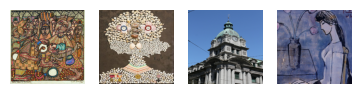

In [14]:
def display_images(dataset, num_images=9):
    plt.figure(figsize=(num_images * 1.1, 5))
    
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

display_images(train_set, num_images=4)

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
num_classes = 2 # Nombre de classes et donc aussi nombre de neurones dans la dernière couche

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(15, (5,5), activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(30, (3,3), activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes)  # Plus de softmax ici
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



model.build((None, image_height, image_width, 3))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 15)      1140      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 15)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 30)      4080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 100, 30)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 300000)            0

In [17]:
epochs=10
tf.get_logger().setLevel('INFO')
history =  model.fit(train_set, validation_data=test_set, epochs=epochs)

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

Epoch 1/10
1603/5821 [=======>......................] - ETA: 2:44 - loss: 0.3949 - accuracy: 0.7881

: 